In [2]:
# ----- Import required packages -----
import netCDF4
import numpy as np
import os
from scipy import io
import matplotlib.pyplot as plt
import os.path
from datetime import datetime
import xarray as xr
import rasterio as rio
import datetime as dt
import matplotlib
import pandas as pd
from datetime import datetime, timedelta
import datetime as dt
from pathlib import Path
from tqdm.notebook import tqdm
from scipy.cluster.vq import kmeans2
from scipy.stats import iqr, mode
from sklearn.cluster import KMeans
import geopandas as gpd

# set dask client to None
client = None

# Select reservoir

In [3]:
start_date = '2022-01-01'
end_date = '2025-10-30'
RESERVOIR = 0
MIN_INTERSECTION_THRESHOLD = 900
buffer_amt = 50 # meters. unlike other types of data, nadir altimetry data works better with a smaller buffer around the reservoir. 
                 # The exact boundary of the reservoir is ideal, but is difficult to obtain automatically, so 50m buffer is a good compromise.

Code to process each swot file and generate altimeter heights.

In [4]:
secd2day=86400 #secd2day=1/86400
mjd_of_time_org=51544

def detect_missing_data(var_FillValue, data):
    if data==var_FillValue:
        data_Flag=1
    else:
        data_Flag=0
    return data_Flag

def process_swot_file(filepath, lat_boundary):
  cycno = filepath.name.split('_')[2][-3:]
  data=netCDF4.Dataset(filepath, 'r')
  elevations = []

  time_01 = data.groups['data_01']['time'][:]
  dim_01hz=len(time_01)
  time_intv1=time_01-0.5
  time_intv2=time_01+0.5
  time20ku= data.groups['data_20']['time'][:]
  dim_20hz=len(time20ku)
  mjd_20_ku = (time20ku/secd2day)+mjd_of_time_org
  lon= data.groups['data_20']['longitude'][:]
  lat= data.groups['data_20']['latitude'][:]

  # Geophysical Corrections
  poletide= data.groups['data_01']['pole_tide'][:]
  solid_earth_tide= data.groups['data_01']['solid_earth_tide'][:]

  # Atmospheric Corrections
  iono_cor_alt= data.groups['data_01']['ku']['iono_cor_alt'][:]
  iono_cor_gim= data.groups['data_01']['ku']['iono_cor_gim'][:]

  mod_dry_tropo_cor_meas= data.groups['data_01']['model_dry_tropo_cor_measurement_altitude'][:]
  # mod_dry_tropo_cor_zero= data.groups['data_20']['model_dry_tropo_cor_zero_altitude'][:]
  mod_wet_tropo_cor_meas= data.groups['data_01']['model_wet_tropo_cor_measurement_altitude'][:]
  # mod_wet_tropo_cor_zero= data.groups['data_20']['model_wet_tropo_cor_zero_altitude'][:]

  # Satellite Altitude
  altimetry= data.groups['data_20']['altitude'][:]
  # Ice Retracking
  range_ice= data.groups['data_20']['ku']['range_ice2'][:]
  sig0_ice= data.groups['data_20']['ku']['sig0_ice2'][:]
  # Ocean Retracking
  range_ocean= data.groups['data_20']['ku']['range_ocean'][:]
  sig0_ocean= data.groups['data_20']['ku']['sig0_ocean'][:]
  range_ocean_flag= data.groups['data_20']['ku']['range_ocean_compression_qual'][:]
  sig0_ocean_flag= data.groups['data_20']['ku']['sig0_ocean_compression_qual'][:]
  # OCOG Retracking
  range_ocog= data.groups['data_20']['ku']['range_ocog'][:]
  sig0_ocog= data.groups['data_20']['ku']['sig0_ocog'][:]
  range_mle3= data.groups['data_20']['ku']['range_ocean_mle3'][:]
  sig0_mle3= data.groups['data_20']['ku']['sig0_ocean_mle3'][:]
  # Sea-Ice Retracking
  range_sea_ice= data.groups['data_20']['ku']['range_seaice'][:]
  sig0_sea_ice= data.groups['data_20']['ku']['sig0_seaice'][:]

  # Surface Class/Type
  surf_class= data.groups['data_20']['surface_classification_flag'][:]

  sel_range = range_ocog.copy()
  sel_sig0 = sig0_ocog.copy()

  ## Fill Value
  pole_tide_01_FillValue=32767
  solid_earth_tide_01_FillValue=32767
  iono_cor_gim_01_ku_FillValue=32767
  mod_dry_tropo_cor_meas_altitude_01_FillValue=32767
  mod_wet_tropo_cor_meas_altitude_01_FillValue=32767

  alt_FillValue=2147483647
  range_FillValue=2147483647
  sig0_FillValue=32767
  elev_FillValue=2147483647

  for i in range(dim_01hz):
    pole_tide_Flag=detect_missing_data(pole_tide_01_FillValue,poletide[i])
    solid_earth_tide_Flag=detect_missing_data(solid_earth_tide_01_FillValue,solid_earth_tide[i])
    iono_cor_gim_ku_Flag=detect_missing_data(solid_earth_tide_01_FillValue,iono_cor_gim[i])
    mod_dry_tropo_cor_meas_altitude_Flag=detect_missing_data(solid_earth_tide_01_FillValue,mod_dry_tropo_cor_meas[i])
    mod_wet_tropo_cor_meas_altitude_Flag=detect_missing_data(solid_earth_tide_01_FillValue,mod_wet_tropo_cor_meas[i])

    correction=poletide[i]+solid_earth_tide[i]+iono_cor_gim[i]+mod_dry_tropo_cor_meas[i]+mod_wet_tropo_cor_meas[i]
    Flags=pole_tide_Flag+solid_earth_tide_Flag+iono_cor_gim_ku_Flag+mod_dry_tropo_cor_meas_altitude_Flag+mod_wet_tropo_cor_meas_altitude_Flag
    mtone = np.where(lat>=lat_boundary[0])
    mttwo = np.where(lat<=lat_boundary[1])
    idxarry = np.intersect1d(mtone,mttwo)
    for j in idxarry:
      alt_F=detect_missing_data(alt_FillValue,altimetry[j])
      range_F=detect_missing_data(range_FillValue,sel_range[j])
      sig0_F=detect_missing_data(sig0_FillValue,sel_sig0[j])

      Flags1=Flags
      Flags2=Flags1+alt_F+range_F+sig0_F
      if Flags2 == 0: 
        if time20ku[j]>=time_intv1[i] and time20ku[j]<=time_intv2[i]:
          correction2=correction
          hgt_20hz=altimetry[j]-(correction2+sel_range[j])
          mjd_20hz=mjd_20_ku[j]
          lon_20hz=lon[j]
          lat_20hz=lat[j]
          sig0_20hz=sig0_ocog[j]
          if hgt_20hz!=np.nan: # and np.abs(hgt_20hz - elev_ocog[j])<=10: ##
              elevations.append((0, 0, 0, 0, 0, 0, 0, 0, 0, cycno, mjd_20hz, lon_20hz, lat_20hz, hgt_20hz, sig0_20hz))
  return elevations


0: Barkley_Dam


<Axes: >

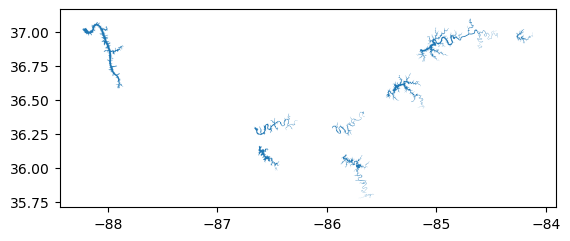

In [10]:
all_reservoirs = gpd.read_file(Path('/tiger1/pdas47/resorr-swot/data/cumberland-reservoir-extents/basin_reservoirs.geojson'))

selected_reservoirs = all_reservoirs['id'].tolist()
res_names = all_reservoirs[['id', 'name']].set_index('id').to_dict()['name']

RESERVOIR_NAME = res_names[RESERVOIR]
print(f'{RESERVOIR}: {RESERVOIR_NAME}')

selected_reservoirs_gdf = all_reservoirs.loc[all_reservoirs['id'].isin(selected_reservoirs)]

selected_reservoirs_gdf.plot()

/tmp/ipykernel_3965884/2881158515.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  plot_lims = BUFFERED_RESERVOIR_GDF.buffer(0.02).bounds


<Axes: >

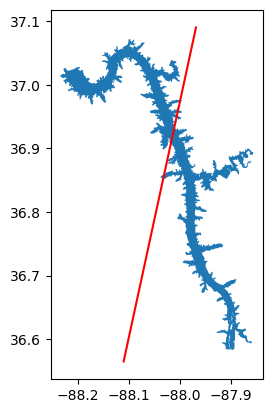

In [ ]:
swot_nadir_tracks_fp = Path("/tiger1/pdas47/resorr-swot/data/swot_orbit/nadir/swot_science_orbit_sept2015-v2_nadir.shp")

RESERVOIR_GDF = selected_reservoirs_gdf[selected_reservoirs_gdf['id']==RESERVOIR]

utm_crs = RESERVOIR_GDF.estimate_utm_crs()
buffered_roi_utm = RESERVOIR_GDF.to_crs(utm_crs).geometry.buffer(buffer_amt)
BUFFERED_RESERVOIR_GDF = buffered_roi_utm.to_crs('epsg:4326')

# get lat-lon boundary
gd_track = gpd.read_file(swot_nadir_tracks_fp)
gd_track_subset = gd_track[gd_track.intersects(RESERVOIR_GDF.geometry.values[0])]

assert len(gd_track_subset) > 0

plot_lims = BUFFERED_RESERVOIR_GDF.buffer(0.02).bounds
minx = plot_lims.values[0][0]
maxx = plot_lims.values[0][2]
miny = plot_lims.values[0][1]
maxy = plot_lims.values[0][3]

f, ax = plt.subplots()
BUFFERED_RESERVOIR_GDF.plot(ax=ax)
gd_track_subset.clip((minx, miny, maxx, maxy)).plot(ax=ax, color='red')

In [15]:
# ----- Functions of processing -----
# Deoutlier functions
def iqr_deoutlier(cyc_hgt_profile):
    IQR = iqr(cyc_hgt_profile, nan_policy='omit')
    high_prct = np.nanquantile(cyc_hgt_profile, 0.75)
    low_prct = np.nanquantile(cyc_hgt_profile, 0.25)
    index_retain_iqr = np.logical_and(cyc_hgt_profile>low_prct-1.5*IQR, cyc_hgt_profile<high_prct+1.5*IQR).flatten()

    return index_retain_iqr

def kmean_water_cluster(cyc_hgt_profile, cyc_sig_profile, hgt_cyc_range_thrd, hgt_cyc_std_thrd):
    hgt_cyc_range = np.nanmax(cyc_hgt_profile) - np.nanmin(cyc_hgt_profile)
    while hgt_cyc_range > hgt_cyc_range_thrd:
        kmeans_cluster = KMeans(n_clusters=2, random_state=42, n_init=10).fit_predict(cyc_hgt_profile)
        cyc_hgt_profile = cyc_hgt_profile[kmeans_cluster==mode(kmeans_cluster, keepdims=True)[0]]
        cyc_sig_profile = cyc_sig_profile[kmeans_cluster==mode(kmeans_cluster, keepdims=True)[0]]
        hgt_cyc_range = np.nanmax(cyc_hgt_profile) - np.nanmin(cyc_hgt_profile)

    hgt_cyc_mean = np.nanmean(cyc_hgt_profile)
    hgt_cyc_std = np.nanstd(cyc_hgt_profile)
    hgt_cyc_errmean = cyc_hgt_profile[:,0] - hgt_cyc_mean
    while hgt_cyc_std > hgt_cyc_std_thrd:
        if np.count_nonzero(~np.isnan(cyc_hgt_profile))==2:
            break
        hgt_cyc_errmean = cyc_hgt_profile - hgt_cyc_mean
        cyc_hgt_profile = cyc_hgt_profile[np.abs(hgt_cyc_errmean)!=np.nanmax(np.abs(hgt_cyc_errmean))]
        cyc_sig_profile = cyc_sig_profile[np.abs(hgt_cyc_errmean)!=np.nanmax(np.abs(hgt_cyc_errmean))]
        hgt_cyc_std = np.nanstd(cyc_hgt_profile)
        hgt_cyc_mean = np.nanmean(cyc_hgt_profile)

    return cyc_hgt_profile, cyc_sig_profile

def decimal_years_to_calendar(excel_date):
  formatted_dates = []

  for decimal_year in excel_date:
    year = int(decimal_year)
    days_fraction = (decimal_year) - (year)
    start_date = datetime(year, 1, 1)
    end_date = datetime(year + 1, 1, 1)
    delta = end_date - start_date

    result_date = start_date + timedelta(days=(days_fraction * delta.days)-1)
    formatted_date = result_date.strftime('%Y-%m-%d')
    formatted_dates.append(formatted_date)

  return formatted_dates

def get_time_series(input_data, index_retain, hgt_cyc_range_thrd, hgt_cyc_std_thrd):
    input_data = input_data[index_retain,:]
    cycno_list = input_data[:,0]
    uniq_cycno = np.unique(cycno_list)

    ct_cyc=0
    FinalSeries=np.empty((len(uniq_cycno),8))
    FinalSeries[:]=np.nan
    for cycno in uniq_cycno[:]:

        index_cyc = cycno_list==cycno
        cyc_data = input_data[index_cyc,:]

        mjd = cyc_data[:,1].reshape(-1,1)
        lon = cyc_data[:,2].reshape(-1,1)
        lat = cyc_data[:,3].reshape(-1,1)
        hgt = cyc_data[:,4].reshape(-1,1)
        sig = cyc_data[:,5].reshape(-1,1)

        hgt, sig = kmean_water_cluster(hgt, sig, hgt_cyc_range_thrd, hgt_cyc_std_thrd)

        cyc_time = (np.nanmean(mjd)+2108-50000)/365.25 +1990
        cyc_lon = np.nanmean(lon)
        cyc_lat = np.nanmean(lat)

        cyc_hgt = np.nanmean(hgt)
        #cyc_unc_hgt = uncertainty(hgt)
        cyc_std_hgt = np.nanstd(hgt)
        cyc_sig = np.nanmean(sig)
        cyc_retain_rate = hgt.shape[0] / cyc_data.shape[0]

        FinalSeries[ct_cyc,:] = [cycno, cyc_time, cyc_lon, cyc_lat, cyc_hgt, cyc_std_hgt, cyc_sig, cyc_retain_rate]

        ct_cyc=ct_cyc+1

    return FinalSeries

def get_time_series_egm08(ip, FinalSeries):
    ## Time-series of water levels (convert to w.r.t. EGM-2008)
    N=ip((FinalSeries[:,3],FinalSeries[:,2]))
    FinalSeries[:,4]=FinalSeries[:,4]-N

    egm08_timeseries = FinalSeries[:,[0,4,5,1,2,3]]

    return egm08_timeseries

In [16]:
from scipy.interpolate import RegularGridInterpolator

# Setting in cluster refinement (Okeowo et al., 2017)
hgt_cyc_range_thrd = 5
hgt_cyc_std_thrd = 0.3

def okeowo_2017(extracted_elevations_fp, min_lat, max_lat, hgt_cyc_range_thrd=5, hgt_cyc_std_thrd=0.3, egm2008_fp="/tiger1/pdas47/tmsosPP/data/geoid/geoidegm2008grid.mat"):
  module1 = extracted_elevations_fp  # extracted path
  module2 = min_lat
  module3 = max_lat

  DataFolder2 = module1

  lat_min = float(module2)
  lat_max = float(module3)

  lat_boundary = [lat_min, lat_max]

  # please input the path of the EGM2008
  lonbp = io.loadmat(egm2008_fp)['lonbp']
  latbp = io.loadmat(egm2008_fp)['latbp']
  grid=io.loadmat(egm2008_fp)['grid']

  ip=RegularGridInterpolator(points=(latbp.flatten(),lonbp.flatten()), values=grid, bounds_error=False, fill_value=np.nan)

  # 4. Altimetry data
  try:
    input_data = np.loadtxt(DataFolder2)[:,9:]
    lat_all=input_data[:,3]
    index_lat_range = np.logical_and(lat_all>lat_boundary[0], lat_all<lat_boundary[1])
    input_data=input_data[index_lat_range,:]

    lon_all = input_data[:,2].reshape(-1,1)
    lat_all = input_data[:,3].reshape(-1,1)
    hgt_all = input_data[:,4].reshape(-1,1)
  except:
    input_data = np.loadtxt(DataFolder2)[9:]

    lat_all=input_data[3]
    index_lat_range = np.logical_and(lat_all>lat_boundary[0], lat_all<lat_boundary[1])
    input_data=input_data[index_lat_range]

    lon_all = input_data[0][2]
    lat_all = input_data[0][3]
    hgt_all = input_data[0][4]

  index_retain_iqr = iqr_deoutlier(hgt_all)
  FinalSeries_iqr = get_time_series(input_data, index_retain_iqr, hgt_cyc_range_thrd, hgt_cyc_std_thrd)

  egm08_timeseries = get_time_series_egm08(ip, FinalSeries_iqr)

  # convert to dataframe
  df = pd.DataFrame(egm08_timeseries, columns=['cycle', 'wse_egm08', 'uncertainty', 'time', 'lon', 'lat'])

  return df

In [ ]:
def classify_swot_nadir_altimeter(
        roi, start_date, end_date,
        intersection_length_threshold=300, # meters. jason class altimeters require at least 300 m of intersection with the ROI.
        swot_nadir_tracks_fp = Path("/tiger1/pdas47/resorr-swot/data/swot_orbit/nadir/swot_science_orbit_sept2015-v2_nadir.shp"),
        swot_nadir_raw_dir = Path("/tiger1/pdas47/resorr-swot/data/swot/raw"),
        swot_nadir_extracted_dir = Path("/tiger1/pdas47/resorr-swot/data/swot/swot_nadir_intermediate"),
        dask_client = None,
        force_extract = False
    ):
    # create output directory if it doesn't exist
    swot_nadir_extracted_dir.mkdir(exist_ok=True)

    # get lat-lon boundary
    gd_track = gpd.read_file(swot_nadir_tracks_fp)
    gd_track_subset = gd_track[gd_track.intersects(roi.geometry.values[0])]

    # filter by intersection length threshold
    nadir_intersects = gpd.GeoDataFrame(geometry=gd_track_subset.intersection(roi.geometry.values[0]).explode(index_parts=False)) # explode = split multi-geometry into single geometries
    nadir_intersects['intersect_length_m'] = nadir_intersects.to_crs(roi.estimate_utm_crs()).length
    nadir_intersects = nadir_intersects[nadir_intersects['intersect_length_m'] > intersection_length_threshold]
    if nadir_intersects.empty:
        raise ValueError(f"No intersections found with length greater than the intersection length threshold ({intersection_length_threshold} m).")
    nadir_intersects['pass_num'] = gd_track_subset['ID_PASS'].loc[nadir_intersects.index]
    nadir_intersects['min_lat'] = nadir_intersects.bounds['miny']
    nadir_intersects['max_lat'] = nadir_intersects.bounds['maxy']
    
    swot_nadir_timeseries_all = []
    # for each pass in ROI, extract data
    for idx, row in nadir_intersects.iterrows():
        extracted_elevations_fp = swot_nadir_extracted_dir / f"SWOT_{RESERVOIR}_{row['pass_num']}_{row['min_lat']}_{row['max_lat']}_info.txt"
        pass_num = row['pass_num']
        lat_min = row['min_lat']
        lat_max = row['max_lat']
        intersect_length = row['intersect_length_m']

        if extracted_elevations_fp.exists() and force_extract==False:  # skip if the processed file already exists
            print(f"Skipping {extracted_elevations_fp} as it already exists")
        else:
            # obtain file paths that match the pass number
            swot_nadir_fps = list(swot_nadir_raw_dir.glob(f'SWOT_GPN_*_{pass_num:03}_*.nc'))
            ipn_files = list(swot_nadir_raw_dir.glob(f'SWOT_IPN_*_{pass_num:03}_*.nc'))
            if len(ipn_files) > 0:
                swot_nadir_fps = swot_nadir_fps + ipn_files


            # filter by start and end date
            swot_nadir_fps = list(filter(
                lambda fp: pd.to_datetime(fp.name.split('_')[4], format='%Y%m%d') >= pd.to_datetime(start_date) \
                    and pd.to_datetime(fp.name.split('_')[4], format='%Y%m%d') <= pd.to_datetime(end_date),
                        swot_nadir_fps
            ))
            
            # process the files. If dask client is provided, process the files parallely
            futures = []
            if dask_client is None:
                with open(extracted_elevations_fp, "w") as text_file:
                    print(f"writing to {extracted_elevations_fp}")
                    for fp in swot_nadir_fps:
                        processed_elevation_info = process_swot_file(fp, lat_boundary=[lat_min, lat_max])

                        for elevation_line in processed_elevation_info:
                            text_file.write("%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%20.6f\t%20.6f\t%20.6f\t%20.6f\t%10.3f\n" % elevation_line)
            else:
                # dask client is provided. Process the files parallely
                futures = []
                for fp in swot_nadir_fps:
                    future = dask_client.submit(process_swot_file, fp, lat_boundary=[lat_min, lat_max])
                    futures.append(future)
                processed_elevation_infos = dask_client.gather(futures)
                
                # write the processed info into text file
                with open(extracted_elevations_fp, "w") as text_file:
                    print(f"Writing to {extracted_elevations_fp}")
                    for processed_elevation_info in processed_elevation_infos:
                        for elevation_line in processed_elevation_info:
                            text_file.write("%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%20.6f\t%20.6f\t%20.6f\t%20.6f\t%10.3f\n" % elevation_line)

        swot_nadir_timeseries = okeowo_2017(
            extracted_elevations_fp, lat_min, lat_max, 
            hgt_cyc_range_thrd, hgt_cyc_std_thrd, 
            egm2008_fp="/tiger1/pdas47/tmsosPP/data/geoid/geoidegm2008grid.mat"
        )
        swot_nadir_timeseries['lon'] = swot_nadir_timeseries['lon'].apply(lambda lon: lon - 360 if lon > 180 else lon)
        swot_nadir_timeseries['pass_num'] = pass_num
        swot_nadir_timeseries['intersect_length_m'] = intersect_length
        swot_nadir_timeseries_all.append(swot_nadir_timeseries)

    return pd.concat(swot_nadir_timeseries_all)

swot_elevations = classify_swot_nadir_altimeter(
    roi=BUFFERED_RESERVOIR_GDF,
    intersection_length_threshold=900, # meters
    start_date=start_date,
    end_date=end_date,
    dask_client=client,
    # dask_client=None,
    force_extract=True
)


writing to /tiger1/pdas47/resorr-swot/data/swot/swot_nadir/SWOT_0_203_36.85053595808387_36.860821462849216_info.txt
writing to /tiger1/pdas47/resorr-swot/data/swot/swot_nadir/SWOT_0_203_36.90857277901294_36.934952398612054_info.txt


In [18]:
swot_elevations

,cycle,wse_egm08,uncertainty,time,lon,lat,pass_num,intersect_length_m
0,7.0,109.434107,0.090973,2023.912832,-88.042512,36.856110,203,1167.769984
1,8.0,109.338433,0.217787,2023.969956,-88.036965,36.854693,203,1167.769984
2,9.0,109.902544,0.128082,2024.027081,-88.038717,36.854663,203,1167.769984
3,10.0,109.623474,0.024300,2024.084205,-88.041502,36.855237,203,1167.769984
4,11.0,109.723855,0.186600,2024.141329,-88.041613,36.856508,203,1167.769984
5,12.0,109.463908,0.178904,2024.198453,-88.039623,36.855947,203,1167.769984
6,13.0,109.239085,0.001650,2024.255578,-88.041946,36.856727,203,1167.769984
7,14.0,110.854196,0.277000,2024.312702,-88.044891,36.856719,203,1167.769984
8,15.0,110.548406,0.131066,2024.369826,-88.040781,36.855482,203,1167.769984
9,16.0,109.391701,0.013950,2024.426950,-88.048235,36.856102,203,1167.769984


In [19]:
elevations_avg = swot_elevations.groupby(['cycle', 'pass_num']).agg({"wse_egm08": 'mean', "time": "mean"}).reset_index()
elevations_avg

,cycle,pass_num,wse_egm08,time
0,7.0,203,108.604829,2023.912832
1,8.0,203,108.615084,2023.969956
2,9.0,203,109.109611,2024.027081
3,10.0,203,109.119152,2024.084205
4,11.0,203,108.804601,2024.141329
5,12.0,203,108.734414,2024.198453
6,13.0,203,108.915016,2024.255578
7,14.0,203,110.032626,2024.312702
8,15.0,203,109.561105,2024.369826
9,16.0,203,109.205117,2024.426950


In [20]:
from datetime import datetime, timedelta

def decimalyear_to_timestamp(time):
    year = int(time)
    rem = time - year
    base = datetime(year, 1, 1)
    result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    
    return pd.Timestamp(result)

elevations_avg['time_parsed'] = elevations_avg['time'].apply(decimalyear_to_timestamp)
elevations_avg

,cycle,pass_num,wse_egm08,time,time_parsed
0,7.0,203,108.604829,2023.912832,2023-11-30 04:24:30.248799
1,8.0,203,108.615084,2023.969956,2023-12-21 00:49:00.292808
2,9.0,203,109.109611,2024.027081,2024-01-10 21:52:31.489021
3,10.0,203,109.119152,2024.084205,2024-01-31 19:39:19.475930
4,11.0,203,108.804601,2024.141329,2024-02-21 17:26:06.260381
5,12.0,203,108.734414,2024.198453,2024-03-13 15:12:50.258718
6,13.0,203,108.915016,2024.255578,2024-04-03 12:59:36.327703
7,14.0,203,110.032626,2024.312702,2024-04-24 10:46:24.342093
8,15.0,203,109.561105,2024.369826,2024-05-15 08:33:10.144908
9,16.0,203,109.205117,2024.426950,2024-06-05 06:19:57.719968


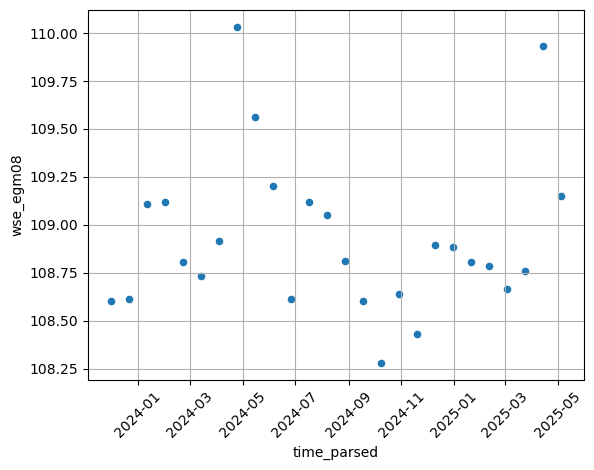

In [32]:
from matplotlib.dates import DateFormatter

f, ax = plt.subplots()
elevations_avg.plot(
    kind='scatter',
    x='time_parsed',
    y='wse_egm08',
    ax=ax
)
ax.grid()
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
ax.xaxis.set_tick_params(rotation=45)

<Axes: >

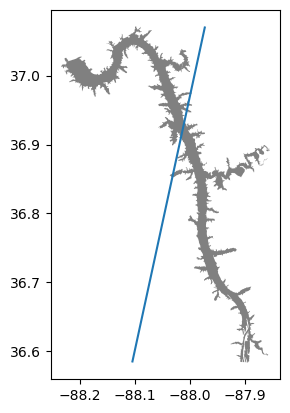

In [35]:
f, ax = plt.subplots()

RESERVOIR_GDF.plot(color='gray', ax=ax)

gd_track_subset.clip(RESERVOIR_GDF.total_bounds).plot(ax=ax)

save data.

In [36]:
time_frac = swot_elevations['time']

In [37]:
swot_elevations['time'] = pd.to_datetime(decimal_years_to_calendar(time_frac))
swot_elevations_ds = swot_elevations.rename({'pass_num': 'pass_ids', 'wse_egm08': 'elevation'}, axis=1).set_index('time').to_xarray()

# add attributes
swot_elevations_ds['cycle'].attrs['long_name'] = 'Cycle number'
swot_elevations_ds['cycle'].attrs['description'] = 'Cycle number of the SWOT altimeter'
swot_elevations_ds['elevation'].attrs['long_name'] = 'Water Surface Elevation'
swot_elevations_ds['elevation'].attrs['description'] = 'Water Surface Elevation above EGM2008'
swot_elevations_ds['elevation'].attrs['units'] = 'm'
swot_elevations_ds['uncertainty'].attrs['long_name'] = 'Uncertainty in Water Surface Elevation'
swot_elevations_ds['uncertainty'].attrs['description'] = 'Uncertainty in Water Surface Elevation'
swot_elevations_ds['uncertainty'].attrs['units'] = 'm'
swot_elevations_ds['lon'].attrs['long_name'] = 'Longitude'
swot_elevations_ds['lon'].attrs['description'] = 'Longitude of the SWOT altimeter'
swot_elevations_ds['lon'].attrs['units'] = 'degrees_east'
swot_elevations_ds['lat'].attrs['long_name'] = 'Latitude'
swot_elevations_ds['lat'].attrs['description'] = 'Latitude of the SWOT altimeter'
swot_elevations_ds['lat'].attrs['units'] = 'degrees_north'
swot_elevations_ds['pass_ids'].attrs['long_name'] = 'Pass IDs of the SWOT altimeter'
swot_elevations_ds['pass_ids'].attrs['description'] = 'Pass IDs of the SWOT altimeter which represents it\'s ground tracks that intersect with the reservoir'
swot_elevations_ds['intersect_length_m'].attrs['long_name'] = 'Intersection Length'
swot_elevations_ds['intersect_length_m'].attrs['description'] = 'Length of intersection between the SWOT altimeter\'s ground track and the reservoir'
swot_elevations_ds['intersect_length_m'].attrs['units'] = 'm'

swot_elevations_ds

<xarray.Dataset> Size: 3kB
Dimensions:             (time: 51)
Coordinates:
  * time                (time) datetime64[ns] 408B 2023-11-29 ... 2025-05-04
Data variables:
    cycle               (time) float64 408B 7.0 8.0 9.0 10.0 ... 30.0 31.0 32.0
    elevation           (time) float64 408B 109.4 109.3 109.9 ... 109.9 109.0
    uncertainty         (time) float64 408B 0.09097 0.2178 ... 0.2291 0.2063
    lon                 (time) float64 408B -88.04 -88.04 ... -88.03 -88.02
    lat                 (time) float64 408B 36.86 36.85 36.85 ... 36.92 36.92
    pass_ids            (time) int64 408B 203 203 203 203 ... 203 203 203 203
    intersect_length_m  (time) float64 408B 1.168e+03 1.168e+03 ... 2.995e+03

save in csv format

In [41]:
csv_save_fp = Path('/tiger1/pdas47/resorr-swot/data/swot/swot_nadir') / f'{RESERVOIR}.csv'
csv_save_fp.parent.mkdir(exist_ok=True, parents=True)

swot_elevations_ds.to_pandas().reset_index().sort_values('time').to_csv(csv_save_fp, index=False)
print(f"Saved at {csv_save_fp}")

Saved at /tiger1/pdas47/resorr-swot/data/swot/swot_nadir/0.csv


end of notebook.